# Modeling Pass The Pigs

After hours of playing this game at a house-warming party, and again playing it for class, I decided why not figure out a way I can be the best there ever was.

The information on how to play and what the game is can be found here:
https://en.wikipedia.org/wiki/Pass_the_Pigs.
Essentially this game is dice with pigs instead of dice.

## Strategy

* Get input data from my class
    * Look for probabilities of outcomes for each dice
    * Maybe look at distributions for outcomes of each dice roll
* Simulate
* ??



## Read the Data

First we read in the data from all teams in my class.

In [1]:
import pandas as pd

data = pd.read_csv("pass_the_pigs.csv")
data

,dot,dot_f,razorback,trotter,snouter,leaning_jowler,other
0,38,52,45,17,2,0,1
1,19,32,32,4,3,0,0
2,14,26,20,7,3,0,2
3,14,21,25,5,1,0,3
4,15,27,40,13,5,0,0
5,32,45,43,10,9,0,0
6,16,24,20,6,1,1,2
7,16,50,53,13,4,1,0
8,24,23,17,7,0,3,0
9,13,25,38,12,3,2,4


Even though the data looks a bit uneven, we find the percentage that each outcome was found as well as the standard deviation for each outcome for each class.

In [2]:
total_rolls = data.values.sum()

#keys for shorthand, I may want to actually type these out in future or just use a basic conversion
keys = {
    'dot' : 'dot',
    'dot_f' : 'nod',
    'razorback' : 'rzb',
    'trotter' : 'ttr',
    'snouter' : 'str',
    'leaning_jowler' : 'ljw',
    'other' : 'otr'
}

#find percentages for each row to calculate standard deviation
cols = list(keys.keys())
shortcut = list(keys.values())

pct_data = data
pct_data[cols] = data[cols].div(data[cols].sum(axis=1), axis=0)

pct_std = pd.DataFrame([pct_data[cols].std()])
total_pct = pd.DataFrame([pct_data[cols].mean()])

pct_std.rename(columns=keys, inplace='True')
total_pct.rename(columns=keys, inplace='True')

# input of relative frequencies from wikipedia
wiki_pct = pd.DataFrame.from_dict({
    'dot' : [.349],
    'nod' : [.302],
    'rzb' : [.224],
    'ttr' : [.088],
    'str' : [.030],
    'ljw' : [.0061],
    'otr' : [.0009]
})

In [3]:
#Standard Deviations of each proportion
pct_std

,dot,nod,rzb,ttr,str,ljw,otr
0,0.057471,0.03772,0.055139,0.026299,0.019023,0.013052,0.017999


In [4]:
#total proportions or the average proportion of values
total_pct

,dot,nod,rzb,ttr,str,ljw,otr
0,0.203947,0.32675,0.328447,0.089408,0.027842,0.007522,0.016084


https://en.wikipedia.org/wiki/Pass_the_Pigs#Relative_frequencies

In [5]:
#relative frequencies from Wikipedia 
wiki_pct

,dot,nod,rzb,ttr,str,ljw,otr
0,0.349,0.302,0.224,0.088,0.03,0.0061,0.0009


What we have now are sampling distributions of the proportions from a sample of size 14 in DataFrames.

## Strategies

A few possible strategies to look at (these may be updated):

    1) Roll until we hit 100
    2) Roll until we hit 20
    3) Roll until the EV is negative
    4) ...

## Expected Values

First, we take a look at the expected value for rolling two pigs with a given score. This is a combination of score and probability. This should also inform a possible strategy for simulation. https://en.wikipedia.org/wiki/Pass_the_Pigs#Scoring

In [6]:
def score(r1, r2, current_score=0):
    scores = {
        'dot' : 1,
        'nod' : 1,
        'rzb' : 5,
        'ttr' : 5,
        'str' : 10,
        'ljw' : 15,
        'otr' : 0
    }
    
    score = 0
    if r1 == r2:
        if r1 == 'dot' or r1 == 'nod':
            score = 1
        else:
            score = scores[r1] * 4
    else:
        if 'dot' in (r1+r2) and 'nod' in (r1+r2):
            score = -1 * current_score
        else:
            score = max(scores[r1], scores[r2])
    return score
            
def expected_value(pct,current_score=0):
    total_score = 0

    #treat this as a global -- maybe change for style later
    for c1 in shortcut:
        for c2 in shortcut:
            total_score += score(c1,c2,current_score) * (pct[c1][0] * pct[c2][0])
    return total_score

expected_value(total_pct, 0)
        


5.85151971969931

## Defining Strategies

1) Roll until we hit 100 (we win)

2) Roll until we hit an arbitrary number (stop_at_n)

In [9]:
def stop_at_n(current_score, n=20, pct=total_pct):
    return current_score >= n

3) Roll until expected value is zero or negative (not used)

In [10]:
def ev_strat(current_score, n=0, pct=total_pct):
    return expected_value(pct,current_score) > 0


In [11]:
cur = 0
while expected_value(total_pct,cur) > 0:
    cur +=1
print(f'rolls until EX = 0: {cur}')

rolls until EX = 0: 43


## Simulation

Let's make a simulation employing each strategy

In [12]:
import numpy as np

def simulation_run(strat, n=20, pct=total_pct, logs=False):
    #note-to-self strat.call()
    
    turns = 0 #let's count the number of turns it takes to reach 100
    
    total_score = 0
    
    # for scoring
    sim_pct = pct.cumsum(axis = 1)
    
    while total_score <= 100:
        turns += 1
        turn_score = 0
        while not strat(turn_score, n=n, pct=pct):
            #determine the rolls 
            [roll1, roll2] = ['','']
            #use a uniform distribution opposite of the cumulative sum s.t. we get a type of roll
            [rand1, rand2] = [np.random.uniform(), np.random.uniform()]
            for col in shortcut:
                if rand1 < sim_pct[col][0] and roll1 == '':
                    roll1 = col
                if rand2 < sim_pct[col][0] and roll2 == '':
                    roll2 = col
            current_score = score(roll1, roll2, turn_score)
            turn_score += current_score
            if current_score < 0:
                break
        if logs:
            print(f'turn: {turn_score}\t total:{total_score}')
        total_score += turn_score
        
    return turns



print(simulation_run(stop_at_n, logs=True))

turn: 20	 total:0
turn: 31	 total:20
turn: 0	 total:51
turn: 21	 total:51
turn: 20	 total:72
turn: 30	 total:92
6


In [13]:
def monte_carlo(m=100,strat=stop_at_n, n=20, pct=total_pct):
    results = []
    for i in range(0,m):
        results.append(simulation_run(strat,pct=pct, n=n))
    return results

Let's try the simulation for 1000 runs of the safe strategy

In [18]:
results = monte_carlo(m=1000,strat =stop_at_n, n=20)
results[0:10]

[5, 5, 6, 5, 5, 6, 6, 4, 12, 6]

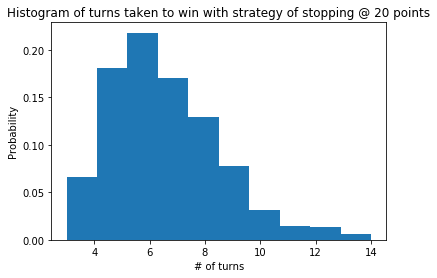

In [19]:
import matplotlib.pyplot as plt
plt.hist(results,density = True, bins= 10)
plt.xlabel('# of turns')
plt.ylabel('Probability')
plt.title('Histogram of turns taken to win with strategy of stopping @ 20 points')
plt.show()

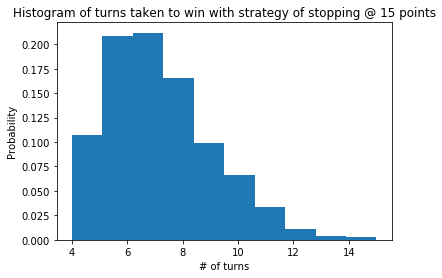

In [17]:
results = monte_carlo(m=1000,strat=stop_at_n, n=15)

plt.hist(results, density = True, bins= 10)
plt.xlabel('# of turns')
plt.ylabel('Probability')
plt.title('Histogram of turns taken to win with strategy of stopping @ 15 points')
plt.show()

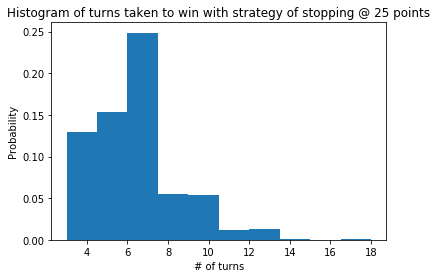

In [20]:
results = monte_carlo(m=1000,strat=stop_at_n,n=25)

plt.hist(results, density =True, bins= 10)
plt.xlabel('# of turns')
plt.ylabel('Probability')
plt.title('Histogram of turns taken to win with strategy of stopping @ 25 points')
plt.show()

In [21]:
avg_turns = []
std_turns = []

rng = range(15,30)

for i in rng:
    print(f'calcuating {i}...')
    cur_results = monte_carlo(m=500,strat=stop_at_n,n=i)
    cur_mean = np.mean(cur_results)
    cur_std = np.std(cur_results)
    avg_turns.append(cur_mean)
    std_turns.append(cur_std)
    print(f'mean of {i}: {cur_mean}\n')
    
avg_turns

calcuating 15...
mean of 15: 7.352

calcuating 16...
mean of 16: 7.052

calcuating 17...
mean of 17: 6.91

calcuating 18...
mean of 18: 6.796

calcuating 19...
mean of 19: 6.758

calcuating 20...
mean of 20: 6.882

calcuating 21...
mean of 21: 6.546

calcuating 22...
mean of 22: 6.3

calcuating 23...
mean of 23: 6.27

calcuating 24...
mean of 24: 6.384

calcuating 25...
mean of 25: 6.16

calcuating 26...
mean of 26: 6.07

calcuating 27...
mean of 27: 6.254

calcuating 28...
mean of 28: 6.068

calcuating 29...
mean of 29: 6.038



[7.352,
 7.052,
 6.91,
 6.796,
 6.758,
 6.882,
 6.546,
 6.3,
 6.27,
 6.384,
 6.16,
 6.07,
 6.254,
 6.068,
 6.038]

Text(0.5, 0, 'score to stop at')

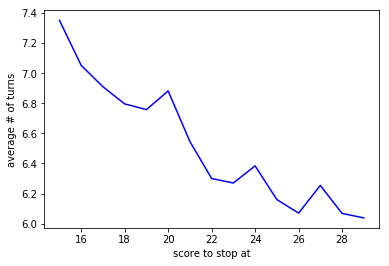

In [22]:
plt.plot(rng,avg_turns, color ='blue')

plt.ylabel('average # of turns')
plt.xlabel('score to stop at')

Text(0.5, 0, 'score to stop at')

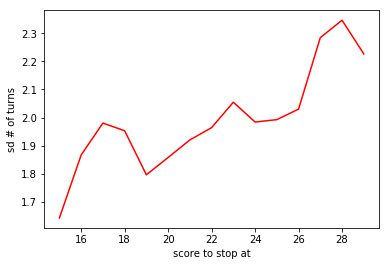

In [23]:
plt.plot(rng,std_turns, color ='red')

plt.ylabel('sd # of turns')
plt.xlabel('score to stop at')

In [24]:
avg_turns = []
std_turns = []

rng = range(25,45)

for i in rng:
    print(f'calcuating {i}...')
    cur_results = monte_carlo(m=500,strat=stop_at_n,n=i)
    cur_mean = np.mean(cur_results)
    cur_std = np.std(cur_results)
    avg_turns.append(cur_mean)
    std_turns.append(cur_std)
    print(f'mean of {i}: {cur_mean}\n')
    
avg_turns

calcuating 25...
mean of 25: 6.358

calcuating 26...
mean of 26: 6.26

calcuating 27...
mean of 27: 6.206

calcuating 28...
mean of 28: 6.096

calcuating 29...
mean of 29: 6.17

calcuating 30...
mean of 30: 6.222

calcuating 31...
mean of 31: 5.724

calcuating 32...
mean of 32: 5.644

calcuating 33...
mean of 33: 5.894

calcuating 34...
mean of 34: 5.898

calcuating 35...
mean of 35: 5.954

calcuating 36...
mean of 36: 6.18

calcuating 37...
mean of 37: 6.404

calcuating 38...
mean of 38: 6.374

calcuating 39...
mean of 39: 6.356

calcuating 40...
mean of 40: 6.464

calcuating 41...
mean of 41: 6.334

calcuating 42...
mean of 42: 6.376

calcuating 43...
mean of 43: 6.542

calcuating 44...
mean of 44: 6.434



[6.358,
 6.26,
 6.206,
 6.096,
 6.17,
 6.222,
 5.724,
 5.644,
 5.894,
 5.898,
 5.954,
 6.18,
 6.404,
 6.374,
 6.356,
 6.464,
 6.334,
 6.376,
 6.542,
 6.434]

Text(0.5, 0, 'score to stop at')

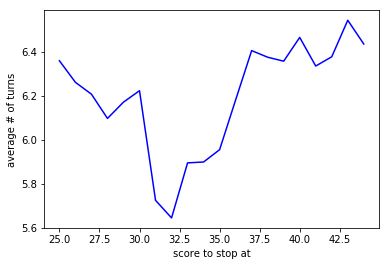

In [25]:
plt.plot(rng,avg_turns, color = 'blue')
plt.ylabel('average # of turns')
plt.xlabel('score to stop at')

Text(0.5, 0, 'score to stop at')

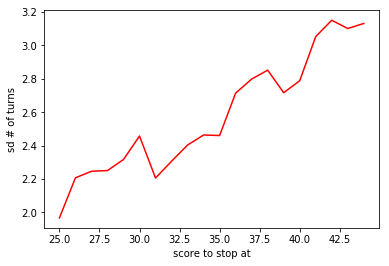

In [26]:
plt.plot(rng,std_turns, color = 'red')
plt.ylabel('sd # of turns')
plt.xlabel('score to stop at')

## Conclusion

From our results, the "score to stop at" with the lowest mean (the best strategy) would be #32. Although from our simulation, the variance increases as the score to stop at increases. Thus although this may be an empirically ideal strategy to get consistently the lowest number of turns, it might not mean you win the most. This is worth further investigation -- possibly using game theory.